<center><h1> Understanding Midwest Hourse Price </h1></center> 

<h2><center> By: Jun Dai </center></h2>

## Step 1: Scrape Zillow, basic house information

In [1]:
## load libraries
#common ones
import os
import time
import sys
import numpy as np
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
# libraries used for scrape
from bs4 import BeautifulSoup
import requests
#from selenium import webdriver
#from selenium.webdriver.common.keys import Keys
#from selenium.webdriver.common.by import By
#import lxml
#from lxml.html.soupparser import fromstring


# setting for basemap
os.environ['PROJ_LIB'] = 'C:/Users/Jun/Anaconda3/Lib/site-packages/mpl_toolkits/basemap'
from mpl_toolkits.basemap import Basemap

In [239]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#set some display settings for notebooks

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#add headers in case you use chromedriver (captchas are no fun); namely used for chromedriver
req_headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.8',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'
}

### cities scraped are:
- Omaha metro: omaha, Council Bluffs, Bellevue, Papillion 
- Des Moines metropolitan:Des Moines, West Des Moines, Ankeny, Urbandale
- Lincoln


In [3]:
def get_df(city):
    #create url variables for each zillow page
    with requests.Session() as s:
        city = city + '/' #*****change this city to what you want!!!!*****

        urls = []
        urls.append('https://www.zillow.com/homes/for_sale/'+city)
        for i in range(2, 26):
            urls.append('https://www.zillow.com/homes/for_sale/'+city+str(i)+'_p/')

        rs = [s.get(url, headers=req_headers) for url in urls]

    #add contents of urls to soup variable from each url
    soups = [BeautifulSoup(r.content, 'html.parser') for r in rs]

    df = pd.DataFrame()

    #all for loops are pulling the specified variable using beautiful soup and inserting into said variable
    for soup in soups:
        temp_df = pd.DataFrame()
        for i in soup:
            address = soup.find_all (class_= 'list-card-addr')
            price = list(soup.find_all (class_='list-card-price'))
            link = soup.find_all (class_= 'list-card-link')

            #create dataframe columns out of variables
            temp_df['prices'] = price
            temp_df['address'] = address
#            temp_df['beds'] = beds

        #create empty url list
        url_refs = []

        #loop through url, pull the href and strip out the address tag
        for link in soup.find_all("article"):
            href = link.find('a',class_="list-card-link")
            addresses = href.find('address')
            addresses.extract()
            url_refs.append(href)

        #import urls into a links column
        temp_df['links'] = url_refs
        temp_df['links'] = temp_df['links'].astype('str')

        #remove html tags
        temp_df['links'] = temp_df['links'].replace('<a class="list-card-link" href="', ' ', regex=True)
        temp_df['links'] = temp_df['links'].replace('" tabindex="0"></a>', ' ', regex=True)
        temp_df['links'] = temp_df['links'].replace('<aaria-hidden="false"class="list-card-linkcarousel-list-card-link-no-activation"href="', '', regex=True)

        if df.shape[0] < temp_df.shape[0]:
            df = temp_df
        else:
            df = pd.concat([df, temp_df], axis=0)
    #convert columns to str
    df['prices'] = df['prices'].astype('str')
    df['address'] = df['address'].astype('str')
 #   df['beds'] = df['beds'].astype('str')

    #remove html tags
    df['prices'] = df['prices'].replace('<div class="list-card-price">', ' ', regex=True)
    df['address'] = df['address'].replace('<address class="list-card-addr">', ' ', regex=True)
    df['prices'] = df['prices'].replace('</div>', ' ', regex=True)
    df['address'] = df['address'].replace('</address>', ' ', regex=True)
    df['prices'] = df['prices'].str.replace(r'\D', '')
    #drop nulls
    df = df[(df['prices'] != '') & (df['prices']!= ' ')]

    #convert column to float
    df['prices'] = df['prices'].astype('float')

    #remove spaces from link column
    df['links'] = df.links.str.replace(' ','')
    
    # print out the dimension to keep track of the size of the dataset
    print('The column datatypes are:')
    print(df.dtypes)
    print('The dataframe shape is:', df.shape)

    #rearrange the columns
    df = df[['prices', 'address', 'links']]
    df.links = df.links.apply(lambda x: x[55:])
    return df

In [4]:
# intitial datasets
# Omaha metro: omaha, Council Bluffs, Bellevue, Papillion, La Vista
# Des Moines metropolitan:Des Moines, West Des Moines, Ankeny, Urbandale
# Lincoln
df_lnk = get_df('lincoln')
df_omaha = get_df('omaha')
df_cb = get_df('council-bluffs')
df_bellevue = get_df('bellevue')

The column datatypes are:
prices     float64
address     object
links       object
dtype: object
The dataframe shape is: (999, 3)
The column datatypes are:
prices     float64
address     object
links       object
dtype: object
The dataframe shape is: (999, 3)
The column datatypes are:
prices     float64
address     object
links       object
dtype: object
The dataframe shape is: (980, 3)
The column datatypes are:
prices     float64
address     object
links       object
dtype: object
The dataframe shape is: (977, 3)


In [5]:
# get data for Papillion and Des Moines
df_papi = get_df('papillion-ne')
df_dm = get_df('des-moines')

The column datatypes are:
prices     float64
address     object
links       object
dtype: object
The dataframe shape is: (993, 3)
The column datatypes are:
prices     float64
address     object
links       object
dtype: object
The dataframe shape is: (986, 3)


In [8]:
# scrape more for cities

df_wdm = get_df('west-des-moines')
df_arkeny = get_df('arkeny')
df_urbandale = get_df('urbandale')

The column datatypes are:
prices     float64
address     object
links       object
dtype: object
The dataframe shape is: (982, 3)
The column datatypes are:
prices     float64
address     object
links       object
dtype: object
The dataframe shape is: (1000, 3)
The column datatypes are:
prices     float64
address     object
links       object
dtype: object
The dataframe shape is: (980, 3)


In [15]:
# combined the different data together

df_combined = pd.concat([df_lnk, df_omaha, df_cb, df_bellevue, df_papi, df_dm, df_wdm, df_arkeny, df_urbandale])

In [17]:
# reset index 

df_combined.reset_index(drop=True, inplace=True)

In [22]:
# save the data

df_combined.to_csv('df_combined.csv')

In [14]:
df_combined= pd.read_csv('df_combined.csv', index_col=0)

In [23]:
# number of dunplicated data

df_combined.duplicated().sum()

4935

In [25]:
# drop the duplicated data

df_lincoln_omaha_desmoine = df_combined[df_combined.duplicated()==False]
df_lincoln_omaha_desmoine.reset_index(drop=True, inplace=True)
df_lincoln_omaha_desmoine.head()

,prices,address,links
0,169900.0,"308 S 53rd St, Lincoln, NE 68510",https://www.zillow.com/homedetails/308-S-53rd-...
1,150000.0,"1262 S 22nd St, Lincoln, NE 68502",https://www.zillow.com/homedetails/1262-S-22nd...
2,175000.0,"5236 Pioneers Blvd, Lincoln, NE 68506",https://www.zillow.com/homedetails/5236-Pionee...
3,287500.0,"1530 Skyline Dr, Lincoln, NE 68506",https://www.zillow.com/homedetails/1530-Skylin...
4,259900.0,"431 Redwood Dr, Lincoln, NE 68510",https://www.zillow.com/homedetails/431-Redwood...


In [26]:
# save the cleaned dataset for this part
df_lincoln_omaha_desmoine.to_csv('df_lnk_omaha_desmoine.csv', index=None)

## step2: Complement the dataset with more information using the link in each column

In [27]:
# This help function takes a house link as input and output the features such as number of 
# bedrooms, number of bathrooms as listed on the website of the house

def get_data_from_lnk(link):
    num_bedroom=np.nan
    num_bathroom = np.nan
    basement=np.nan
    flooring = np.nan
    heating = np.nan
    cooling = np.nan
    livable_area = np.nan
    num_parking = np.nan
    num_garage = np.nan
    lot_size = np.nan
    home_type = np.nan
    roof = np.nan
    year_built = np.nan
    style = np.nan
    school_rating = np.nan
    remodel_year = np.nan
    lat = np.nan
    long = np.nan
    with requests.Session() as s:
        r = s.get(link, headers=req_headers)
        soup = BeautifulSoup(r.content, 'html.parser')
        temp = [i.get_text(strip=True) for i in soup.find_all('span', {'class':re.compile('Text-aiai24-0.*')})]
        # get latitude and longitude
        try:
            ex = soup.findAll('script', {'type' : 'application/ld+json'})
            test = str(ex[0]).lower()
            index1 = str(ex[0]).lower().index('longitude')
            index2 = str(ex[0]).lower().index('latitude')
            long, lat = str(ex[0])[index1+11:index1+11+10], test[index2+10:index2+10+10]
        except:
            pass

        # collect other house information
        for i, data in enumerate(temp):
            if data.lower().startswith('bedrooms:'):
                num_bedroom = data.split(':')[1]
            elif data.lower().startswith('bathrooms:'):
                num_bathroom = data.split(':')[1]
            elif data.lower().startswith('basement:'):
                basement = data.split(':')[1]
            elif data.lower().startswith('flooring:'):
                flooring = data.split(':')[1]
            elif data.lower().startswith('heating features:'):
                heating = data.split(':')
            elif data.lower().startswith('cooling:'):
                cooling = data.split(':')[1]
            elif data.lower().startswith('total interior livable area:'):
                livable_area = data.split(':')[1]
            elif data.lower().startswith('total spaces:'):
                num_parking = data.split(':')[1]
            elif data.lower().startswith('garage spaces:'):
                num_garage = data.split(':')[1]
            elif data.lower().startswith('lot size:'):
                lot_size = data.split(':')[1]
            elif data.lower().startswith('home type:'):
                home_type = data.split(':')[1]
            elif data.lower().startswith('roof:'):
                roof = data.split(':')[1]
            elif data.lower().startswith('year built:'):
                year_built = data.split(':')[1]
            elif data.lower().startswith('major remodel year:'):
                remodel_year = data.split(':')[1]
            elif data.startswith('GreatSchools rating'):
                school_rating = temp[i+1]
    return num_bedroom, num_bathroom, basement, flooring, heating, cooling, \
           livable_area, num_parking, num_garage, lot_size, home_type, roof, \
           year_built, remodel_year, school_rating, lat, long
            

In [29]:
# collect data for all links

# here all links in the previous sraped dataset are looped over and further scraped.
# this part is seperated into two parts to avoid ip banning from zillow.

bedrooms = []
bathrooms = []
basement_info = []
flooring_info = []
heating_info = []
cooling_info = []
livable_size = []
parkings = []
garages = []
lotsize = []
hometype = []
roof_type = []
built_year = []
major_remodel = []
school_rate = []
latitude = []
logitude = []
for link in df_lincoln_omaha_desmoine.links[:1900]:
    num_bedroom, num_bathroom, basement, flooring, heating, cooling, \
    livable_area, num_parking, num_garage, lot_size, home_type, roof, \
    year_built, remodel_year, school_rating, lat, long = get_data_from_lnk(link)
    bedrooms.append(num_bedroom)
    bathrooms.append(num_bathroom)
    basement_info.append(basement)
    flooring_info.append(flooring)
    heating_info.append(heating)
    cooling_info.append(cooling)
    livable_size.append(livable_area)
    parkings.append(num_parking)
    garages.append(num_garage)
    lotsize.append(lot_size)
    hometype.append(home_type)
    roof_type.append(roof)
    built_year.append(year_built)
    major_remodel.append(remodel_year)
    school_rate.append(school_rating)
    latitude.append(lat)
    logitude.append(long)

In [31]:
# zillow bans ip when scraping, so I split the IPs and do them seperately

for link in df_lincoln_omaha_desmoine.links[1900:]:
    num_bedroom, num_bathroom, basement, flooring, heating, cooling, \
    livable_area, num_parking, num_garage, lot_size, home_type, roof, \
    year_built, remodel_year, school_rating, lat, long = get_data_from_lnk(link)
    bedrooms.append(num_bedroom)
    bathrooms.append(num_bathroom)
    basement_info.append(basement)
    flooring_info.append(flooring)
    heating_info.append(heating)
    cooling_info.append(cooling)
    livable_size.append(livable_area)
    parkings.append(num_parking)
    garages.append(num_garage)
    lotsize.append(lot_size)
    hometype.append(home_type)
    roof_type.append(roof)
    built_year.append(year_built)
    major_remodel.append(remodel_year)
    school_rate.append(school_rating)
    latitude.append(lat)
    logitude.append(long)

In [32]:
# make a copy of the scraped dataset

df_short = df_lincoln_omaha_desmoine.copy()

In [33]:
# append information to the dataset

df_short['num_bedroom'] = bedrooms
df_short['num_bathroom'] = bathrooms
df_short['basement'] = basement_info
df_short['flooring'] = flooring_info
df_short['heating'] = heating_info
df_short['cooling'] = cooling_info
df_short['livable_area'] = livable_size
df_short['num_parking'] = parkings
df_short['num_garage'] = garages
df_short['lot_size'] = lotsize
df_short['home_type'] = hometype
df_short['roof'] = roof_type
df_short['year_built'] = built_year
df_short['year_remodel'] = major_remodel
df_short['school_rating'] = school_rate
df_short['latitude'] = latitude
df_short['longitude'] = logitude
    

In [34]:
# move the price to the last of the column

cols = list(df_short.columns)
col_names = list(cols[1:])
col_names.append(cols[0])
df_short = df_short[col_names]
# reset index
df_short.reset_index(drop=True, inplace=True)

In [41]:
# save the data

import pickle

df_short.to_csv('raw_df_total.csv', index=True)
pickle.dump(df_short, open( "df_short.pkl", "wb" ))

In [42]:
# fix the string issue in latitude and longitude

df_short['latitude'] = df_short.latitude.apply(lambda x:(re.sub(r'[/:{},"a-zA-Z]', '', str(x))))
df_short['longitude'] = df_short.longitude.apply(lambda x:(re.sub(r'[/:{},"a-zA-Z]', '', str(x))))

df_short.latitude = df_short.latitude.apply(lambda x: float(x) if len(x)>0 else np.nan)
df_short.longitude = df_short.longitude.apply(lambda x: float(x) if len(x)>0 else np.nan)

In [43]:
# change the datatype from str to numeric for the following features

df_short.num_bathroom = df_short.num_bathroom.astype('float')
df_short.num_bedroom  = df_short.num_bedroom.astype('float')
df_short.num_garage = df_short.num_garage.astype('float')
df_short.num_parking = df_short.num_parking.astype('float')

In [44]:
# pickle the updated dataframe

pickle.dump(df_short, open( "df_short.pkl", "wb" ))

## Step 3: Exploratory Data Analysis

In [1]:
# load previous saved data

import pickle
df_zillow = pickle.load(open( "df_short.pkl", "rb" ))

In [132]:
df_zillow.head()

,address,links,num_bedroom,num_bathroom,basement,flooring,heating,cooling,livable_area,num_parking,num_garage,lot_size,home_type,roof,year_built,year_remodel,school_rating,latitude,longitude,prices
0,"308 S 53rd St, Lincoln, NE 68510",https://www.zillow.com/homedetails/308-S-53rd-...,3.0,2.0,None,"Carpet, Hardwood","[Heating features, Forced air, Gas]",Central Air,"1,320 sqft",1.0,1.0,"8,276 sqft",Single Family,Other,1958,NaN,7,40.811314,-96.647384,169900.0
1,"1262 S 22nd St, Lincoln, NE 68502",https://www.zillow.com/homedetails/1262-S-22nd...,3.0,2.0,Yes,NaN,"[Heating features, Forced air, Gas]",Central Air,"1,728 sqft",1.0,1.0,"6,969 sqft",Single Family,Composition,1910,NaN,3,40.800304,-96.688903,150000.0
2,"5236 Pioneers Blvd, Lincoln, NE 68506",https://www.zillow.com/homedetails/5236-Pionee...,3.0,2.0,Partially finished,"Hardwood, Linoleum / Vinyl","[Heating features, Gas, Forced air]",Central Air,"1,604 sqft",NaN,1.0,0.17 acres,Single Family,Composition,1948,NaN,4,40.770038,-96.648379,175000.0
3,"1530 Skyline Dr, Lincoln, NE 68506",https://www.zillow.com/homedetails/1530-Skylin...,2.0,3.0,Partially finished,NaN,"[Heating features, Gas, Forced air]",Central Air,"2,124 sqft",NaN,2.0,0.26 acres,Single Family,Composition,1961,NaN,6,40.797557,-96.639582,287500.0
4,"431 Redwood Dr, Lincoln, NE 68510",https://www.zillow.com/homedetails/431-Redwood...,4.0,3.0,Finished,Hardwood,"[Heating features, Gas, Forced air]",Central Air,"2,229 sqft",NaN,2.0,0.23 acres,Single Family,Composition,1966,NaN,8,40.808858,-96.610494,259900.0


In [153]:
# data types
df_zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        3933 non-null   object 
 1   links          3933 non-null   object 
 2   num_bedroom    3291 non-null   float64
 3   num_bathroom   3194 non-null   float64
 4   basement       2176 non-null   object 
 5   flooring       2172 non-null   object 
 6   heating        3135 non-null   object 
 7   cooling        1395 non-null   object 
 8   livable_area   3286 non-null   object 
 9   num_parking    1500 non-null   float64
 10  num_garage     2894 non-null   float64
 11  lot_size       2783 non-null   object 
 12  home_type      3295 non-null   object 
 13  roof           3032 non-null   object 
 14  year_built     3185 non-null   object 
 15  year_remodel   479 non-null    object 
 16  school_rating  3933 non-null   object 
 17  latitude       3933 non-null   float64
 18  longitud

In [39]:
# statistical informations

df_zillow.describe()

,num_bedroom,num_bathroom,num_parking,num_garage,latitude,longitude,prices
count,3314.000000,3217.000000,1521.000000,2916.000000,3933.000000,3933.000000,3.961000e+03
mean,3.251660,2.629468,1.756082,2.054870,41.792542,-97.574829,4.205441e+05
std,1.780611,1.261308,1.359302,1.340646,1.782775,7.532810,7.655944e+05
min,0.000000,0.000000,0.000000,0.000000,39.820756,-122.217460,1.100000e+03
25%,3.000000,2.000000,1.000000,1.000000,41.129314,-96.604080,1.500000e+05
50%,3.000000,3.000000,2.000000,2.000000,41.290449,-96.037704,2.649000e+05
75%,4.000000,3.000000,3.000000,3.000000,41.589413,-93.783732,4.290000e+05
max,81.000000,13.000000,13.000000,18.000000,47.655671,-93.508468,2.750000e+07


In [147]:
df_zillow.isna().sum()

address             0
links               0
num_bedroom       647
num_bathroom      744
basement         1770
flooring         1771
heating           805
cooling          2560
livable_area      652
num_parking      2440
num_garage       1045
lot_size         1159
home_type         643
roof              907
year_built        754
year_remodel     3477
school_rating       5
latitude           28
longitude          28
prices              0
dtype: int64

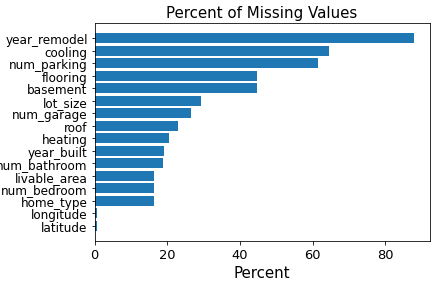

In [57]:
# check null values

missing_values = df_zillow.isna().sum()
missing_values = missing_values.sort_values(ascending=True)
plt.barh(missing_values[4:].index, 100*missing_values[4:].values/df_zillow.shape[0])
with plt.style.context('seaborn-white') as _:
    plt.title('Percent of Missing Values', fontsize=15)
    plt.xlabel('Percent', fontsize=15)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=12)
    plt.savefig('na_ration.png')

In [148]:
# drop the rows with null latitude and longitude

df_zillow = df_zillow[df_zillow.latitude.isna()==False]
df_zillow.reset_index(drop=True, inplace=True)

In [96]:
df_test = pd.read_csv('Omaha.csv', index_col=0)
df_test.head()

,links,num_bedroom,num_bathroom,basement,heating,cooling,livable_area,num_parking,num_garage,lot_size,home_type,roof,year_built,year_remodel,school_rating,latitude,longitude,prices
address,,,,,,,,,,,,,,,,,,
"6035 Lafayette Ave, Omaha, NE 68132",https://www.zillow.com/homedetails/6035-Lafaye...,3.0,2.0,Yes,"['Heating features', 'Forced air, Gas']",Central Air,1490.0,1.0,1.0,0.25,Single Family,Composition,1955.0,NaN,2,41.271194,-96.006736,170000
"13311 Slayton St, Omaha, NE 68138",https://www.zillow.com/homedetails/13311-Slayt...,3.0,3.0,Yes,"['Heating features', 'Forced air, Gas']",Central Air,1668.0,2.0,2.0,8973.00,Single Family,Composition,1973.0,NaN,7,41.140034,-96.121963,215000
"5808 S 239th St, Elkhorn, NE 68022",https://www.zillow.com/homedetails/5808-S-239t...,5.0,6.0,Yes,"['Heating features', 'Forced air, Gas']",Central Air,4801.0,3.0,3.0,0.31,Single Family,Composition,2015.0,NaN,8,41.198498,-96.290756,675000
"3021 S 94th St, Omaha, NE 68124",https://www.zillow.com/homedetails/3021-S-94th...,3.0,3.0,Yes,"['Heating features', 'Forced air, Gas']",Central Air,1976.0,2.0,2.0,10018.00,Single Family,Composition,1964.0,NaN,8,41.231110,-96.059982,196500
"111 S 51st St, Omaha, NE 68132",https://www.zillow.com/homedetails/111-S-51st-...,3.0,3.0,Yes,"['Heating features', 'Forced air, Gas']",Central Air,1898.0,2.0,2.0,6534.00,Single Family,Composition,1921.0,NaN,5,41.258778,-95.992301,265000


In [98]:
df_test.longitude.describe()

count    2867.000000
mean      -98.234162
std         8.824886
min      -122.217460
25%       -96.186679
50%       -95.949574
75%       -93.692191
max       -93.508468
Name: longitude, dtype: float64

In [103]:
df_test.prices.skew()

14.320342859604006

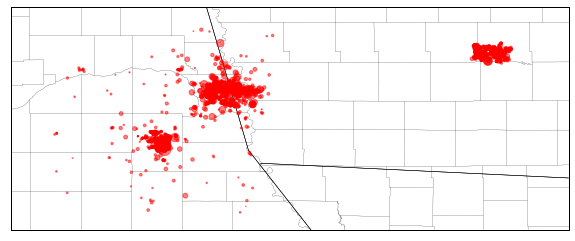

In [150]:
# display the location of houses

lats = df_test.lat.values
longs = df_test.long.values
price = df_test.prices.values

# determine range to print based on min, max lat and long of the data
#margin = .2 # buffer to add to the range
#lat_min = min(lats) - margin
#lat_max = max(lats) + margin
#long_min = min(longs) - margin
#long_max = max(longs) + margin

plt.figure(figsize=(10, 6))
# create map using BASEMAP
m = Basemap(llcrnrlon=-98,
            llcrnrlat=40,
            urcrnrlon=-93,
            urcrnrlat=42,
#            projection='merc',
            )
#m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawcounties()
m.drawmapboundary()
#m.fillcontinents(color='lightgray',zorder=0)
#m.fillcontinents(color = 'white',lake_color='#46bcec')
# convert lat and long to map projection coordinates
#lat_s, long_s = m(lats, longs)
# plot points as red dots
m.scatter(longs, lats, marker='o', color='red', zorder=10, latlon=True, s=price/50000, alpha=0.5)
plt.savefig('house_scattering.png')

## Step 4: Data Preparation

In [151]:
liveablt_units = []
num_nan = 0
for l_u in df_zillow.livable_area.values:
    if isinstance(l_u, str):
        liveablt_units.append(l_u.split(' ')[1])
    else:
        num_nan = num_nan + 1
print(np.unique(liveablt_units))
print(num_nan)

['sqft']
647


In [152]:
lotsize_units = []
num_nan = 0
for lot in df_zillow.lot_size.values:
    if isinstance(lot, str):
        lotsize_units.append(lot.split(' ')[1])
    else:
        num_nan = num_nan + 1
print(np.unique(lotsize_units))
print(num_nan)

['Acres' 'acres' 'sqft']
1150


It is observed liveable_area only have one unit, sqft, while lotsize has acres and sqft, so we need to unify the units.

In [167]:
# convert string to numeric for lot_size and livable area

def size_to_numeric(s):
    if isinstance(s, str):
        # if a s is a string do the following
        # '12,340 sqft' ->'12,340' and 'sqft' ->'12340'
        result = s.split(' ')
        size = result[0]
        size = re.sub(r'[,a-zA-Z]', '', size)
        if 'acre' in result[1].strip().lower():
            return float(size)*43560
        else:
            return float(size)
    else:
        # if not str, return itself (nan)
        return s



In [175]:
# apply the function to liveable_area and lot_size

df_zillow.livable_area = df_zillow.livable_area.apply(size_to_numeric)
df_zillow.lot_size = df_zillow.lot_size.apply(size_to_numeric)


In [179]:
# fill the null values with median value for livable area and lotsize

livable_median = df_zillow.livable_area.median()
df_zillow.livable_area.fillna(livable_median, inplace=True)

lotsize_median = df_zillow.lot_size.median()
df_zillow.lot_size.fillna(lotsize_median, inplace=True)

In [182]:
df_zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        3933 non-null   object 
 1   links          3933 non-null   object 
 2   num_bedroom    3291 non-null   float64
 3   num_bathroom   3194 non-null   float64
 4   basement       2176 non-null   object 
 5   flooring       2172 non-null   object 
 6   heating        3135 non-null   object 
 7   cooling        1395 non-null   object 
 8   livable_area   3933 non-null   float64
 9   num_parking    1500 non-null   float64
 10  num_garage     2894 non-null   float64
 11  lot_size       3933 non-null   float64
 12  home_type      3295 non-null   object 
 13  roof           3032 non-null   object 
 14  year_built     3185 non-null   object 
 15  year_remodel   479 non-null    object 
 16  school_rating  3933 non-null   object 
 17  latitude       3933 non-null   float64
 18  longitud

In [183]:
# fill the bathroom and bedroom with median

num_bathroom_median = df_zillow.num_bathroom.median()
df_zillow.num_bathroom.fillna(num_bathroom_median, inplace=True)
num_bedroom_median = df_zillow.num_bedroom.median()
df_zillow.num_bedroom.fillna(num_bedroom_median, inplace=True)

In [185]:
df_zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        3933 non-null   object 
 1   links          3933 non-null   object 
 2   num_bedroom    3933 non-null   float64
 3   num_bathroom   3933 non-null   float64
 4   basement       2176 non-null   object 
 5   flooring       2172 non-null   object 
 6   heating        3135 non-null   object 
 7   cooling        1395 non-null   object 
 8   livable_area   3933 non-null   float64
 9   num_parking    1500 non-null   float64
 10  num_garage     2894 non-null   float64
 11  lot_size       3933 non-null   float64
 12  home_type      3295 non-null   object 
 13  roof           3032 non-null   object 
 14  year_built     3185 non-null   object 
 15  year_remodel   479 non-null    object 
 16  school_rating  3933 non-null   object 
 17  latitude       3933 non-null   float64
 18  longitud

In [ ]:
'''
link = df_lincoln_omaha_desmoine.links[0]
r = s.get(link, headers=req_headers)
soup = BeautifulSoup(r.content, 'html.parser')
#temp = [i.get_text(strip=True) for i in soup.find_all('span', {'class':re.compile('Text-aiai24-0.*')})]
# get latitude and longitude
ex = soup.findAll('script', {'type' : 'application/ld+json'})
'''

In [192]:
df_zillow_drop_schoolrating = df_zillow[df_zillow.school_rating.apply(lambda x: x.isnumeric())]
df_zillow_drop_schoolrating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3796 entries, 0 to 3932
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        3796 non-null   object 
 1   links          3796 non-null   object 
 2   num_bedroom    3796 non-null   float64
 3   num_bathroom   3796 non-null   float64
 4   basement       2113 non-null   object 
 5   flooring       2111 non-null   object 
 6   heating        3056 non-null   object 
 7   cooling        1352 non-null   object 
 8   livable_area   3796 non-null   float64
 9   num_parking    1457 non-null   float64
 10  num_garage     2820 non-null   float64
 11  lot_size       3796 non-null   float64
 12  home_type      3214 non-null   object 
 13  roof           2955 non-null   object 
 14  year_built     3105 non-null   object 
 15  year_remodel   464 non-null    object 
 16  school_rating  3796 non-null   object 
 17  latitude       3796 non-null   float64
 18  longitud

In [195]:
df_zillow.to_csv('df_zillow_1118.csv', index=True)

In [193]:
df_zillow_drop_schoolrating.school_rating = df_zillow_drop_schoolrating.school_rating.astype('int')
df_zillow_drop_schoolrating.describe()

C:\Users\Jun\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,num_bedroom,num_bathroom,livable_area,num_parking,num_garage,lot_size,school_rating,latitude,longitude,prices
count,3796.000000,3796.000000,3796.000000,1457.000000,2820.000000,3.796000e+03,3796.000000,3796.000000,3796.000000,3.796000e+03
mean,3.203899,2.687302,2114.622629,1.746740,2.052482,3.323675e+04,5.351423,41.812491,-97.606030,4.170504e+05
std,1.646506,1.135582,1309.173625,1.360639,1.340587,1.897228e+05,2.320397,1.798189,7.616666,7.406930e+05
min,0.000000,0.000000,300.000000,0.000000,0.000000,4.400000e+01,1.000000,39.820756,-122.217460,1.100000e+03
25%,3.000000,2.000000,1425.750000,1.000000,1.000000,7.840800e+03,3.000000,41.139625,-96.605819,1.549000e+05
50%,3.000000,3.000000,1792.500000,2.000000,2.000000,9.583200e+03,6.000000,41.296155,-96.027045,2.650000e+05
75%,4.000000,3.000000,2459.000000,3.000000,3.000000,1.132560e+04,7.000000,41.590215,-93.782902,4.280675e+05
max,81.000000,13.000000,20670.000000,13.000000,18.000000,7.013160e+06,10.000000,47.655671,-93.508468,2.750000e+07


In [194]:
df_zillow_drop_schoolrating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3796 entries, 0 to 3932
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        3796 non-null   object 
 1   links          3796 non-null   object 
 2   num_bedroom    3796 non-null   float64
 3   num_bathroom   3796 non-null   float64
 4   basement       2113 non-null   object 
 5   flooring       2111 non-null   object 
 6   heating        3056 non-null   object 
 7   cooling        1352 non-null   object 
 8   livable_area   3796 non-null   float64
 9   num_parking    1457 non-null   float64
 10  num_garage     2820 non-null   float64
 11  lot_size       3796 non-null   float64
 12  home_type      3214 non-null   object 
 13  roof           2955 non-null   object 
 14  year_built     3105 non-null   object 
 15  year_remodel   464 non-null    object 
 16  school_rating  3796 non-null   int32  
 17  latitude       3796 non-null   float64
 18  longitud

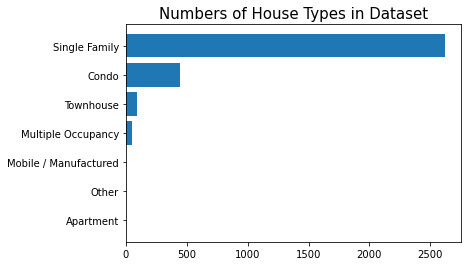

In [202]:
# plot the home_type

home_type_counts = df_zillow_drop_schoolrating.home_type.value_counts(ascending=True)

plt.barh(home_type_counts.index, home_type_counts.values)
plt.title('Numbers of House Types in Dataset', fontsize=15)
plt.savefig('home_type.png')

In [205]:
# define a function to clean the 
def trim_hometype(s):
    if isinstance(s, str):
        if 'condo' in s.lower():
            return 'condo'
        elif 'single' in s.lower():
            return 'single_family'
        elif 'townhouse' in s.lower():
            return 'townhouse'
    else:
        return np.nan

In [207]:
df_zillow_drop_schoolrating.home_type = df_zillow_drop_schoolrating.home_type.apply(trim_hometype)
df_zillow_drop_schoolrating = df_zillow_drop_schoolrating[df_zillow_drop_schoolrating.home_type.notna()]

C:\Users\Jun\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [211]:
df_zillow_drop_schoolrating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3153 entries, 0 to 3932
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        3153 non-null   object 
 1   links          3153 non-null   object 
 2   num_bedroom    3153 non-null   float64
 3   num_bathroom   3153 non-null   float64
 4   basement       2065 non-null   object 
 5   flooring       2097 non-null   object 
 6   heating        2996 non-null   object 
 7   cooling        1339 non-null   object 
 8   livable_area   3153 non-null   float64
 9   num_parking    1421 non-null   float64
 10  num_garage     2774 non-null   float64
 11  lot_size       3153 non-null   float64
 12  home_type      3153 non-null   object 
 13  roof           2899 non-null   object 
 14  year_built     3044 non-null   object 
 15  year_remodel   452 non-null    object 
 16  school_rating  3153 non-null   int32  
 17  latitude       3153 non-null   float64
 18  longitud

In [215]:
def trim_roof(s):
    if isinstance(s, str):
        if 'metal' in s.lower():
            return 'metal'
        elif 'asphalt' in s.lower():
            return 'asphalt_compisition'
        elif 'comp' in s.lower():
            return 'asphalt_compisition'
        elif 'tile' in s.lower():
            return 'tile_slate'
        elif 'slate' in s.lower():
            return 'tile_slate'
        elif 'wood' in s.lower():
            return 'wood_cedar'
        elif 'cedar' in s.lower():
            return 'wood_cedar'
        elif 'rubber' in s.lower():
            return 'rubber'
        else:
            return 'other'
    else:
        return 'unknown'

In [216]:
df_zillow_drop_schoolrating['roof'] = df_zillow_drop_schoolrating.roof.apply(trim_roof)

C:\Users\Jun\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [219]:
# fill number of parking and number of garage with median value

garage_median = df_zillow_drop_schoolrating.num_garage.median()
df_zillow_drop_schoolrating.num_garage.fillna(garage_median, inplace=True)
parking_median = df_zillow_drop_schoolrating.num_parking.median()
df_zillow_drop_schoolrating.num_parking.fillna(parking_median, inplace=True)

C:\Users\Jun\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [229]:
df_zillow_drop_schoolrating.head()

,address,links,num_bedroom,num_bathroom,basement,flooring,heating,cooling,livable_area,num_parking,num_garage,lot_size,home_type,roof,year_built,year_remodel,school_rating,latitude,longitude,prices
0,"308 S 53rd St, Lincoln, NE 68510",https://www.zillow.com/homedetails/308-S-53rd-...,3.0,2.0,None,"Carpet, Hardwood","[Heating features, Forced air, Gas]",Central Air,1320.0,1.0,1.0,8276.0,single_family,other,1958,NaN,7,40.811314,-96.647384,169900.0
1,"1262 S 22nd St, Lincoln, NE 68502",https://www.zillow.com/homedetails/1262-S-22nd...,3.0,2.0,Yes,NaN,"[Heating features, Forced air, Gas]",Central Air,1728.0,1.0,1.0,6969.0,single_family,asphalt_compisition,1910,NaN,3,40.800304,-96.688903,150000.0
2,"5236 Pioneers Blvd, Lincoln, NE 68506",https://www.zillow.com/homedetails/5236-Pionee...,3.0,2.0,Partially finished,"Hardwood, Linoleum / Vinyl","[Heating features, Gas, Forced air]",Central Air,1604.0,2.0,1.0,7405.2,single_family,asphalt_compisition,1948,NaN,4,40.770038,-96.648379,175000.0
3,"1530 Skyline Dr, Lincoln, NE 68506",https://www.zillow.com/homedetails/1530-Skylin...,2.0,3.0,Partially finished,NaN,"[Heating features, Gas, Forced air]",Central Air,2124.0,2.0,2.0,11325.6,single_family,asphalt_compisition,1961,NaN,6,40.797557,-96.639582,287500.0
4,"431 Redwood Dr, Lincoln, NE 68510",https://www.zillow.com/homedetails/431-Redwood...,4.0,3.0,Finished,Hardwood,"[Heating features, Gas, Forced air]",Central Air,2229.0,2.0,2.0,10018.8,single_family,asphalt_compisition,1966,NaN,8,40.808858,-96.610494,259900.0


In [234]:
df_zillow_drop_schoolrating.basement.value_counts()

Finished                                 629
Partially finished                       597
Yes                                      540
Unfinished                               169
None                                      71
Full                                      19
Fully Finished, Daylight                   8
Fully Finished                             7
Partial                                    7
Daylight                                   3
Partly Finished, Partial                   2
Full, Drain Tiled, Sump Pump               1
Partially Finished                         1
Living Room                                1
PARTIAL, CRAWL SPACE, PARTLY FINISHED      1
Pour, Partial                              1
Full, Fully Finished                       1
Full, Partly Finished                      1
Crawl                                      1
Finished (Livable)                         1
Full, Unfinished                           1
Slab                                       1
Full, Drai

In [236]:
def treat_basement(s):
    if isinstance(s, str):
        if 'none' in s.lower():
            return 'none'
        elif 'part' in s.lower():
            return 'partially_finished'
        elif 'crawl' in s.lower():
            return 'partially_finished'
        elif 'unfinished' in s.lower():
            return 'unfinished'
        elif 'full' in s.lower():
            return 'finished'
        elif 'finished' in s.lower():
            return 'finished'
        elif 'yes' in s.lower():
            return 'finished'
        else:
            return 'other'
    else:
        return 'unknown'

In [238]:
df_zillow_drop_schoolrating.basement = df_zillow_drop_schoolrating.basement.apply(treat_basement)

C:\Users\Jun\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [241]:
df_zillow_drop_schoolrating.flooring.value_counts()

Hardwood                                                        306
Carpet, Hardwood, Tile                                          189
Tile, Carpet, Hardwood                                          141
Carpet, Linoleum / Vinyl                                        134
Laminate                                                        118
                                                               ... 
Carpet, Concrete, Hardwood, Slate, Tile                           1
Tile, Carpet, Concrete, Hardwood, Laminate, Linoleum / Vinyl      1
Carpet, Concrete, Linoleum / Vinyl, Tile, Other                   1
Other, Carpet, Hardwood, Slate                                    1
Tile, Other, Carpet, Laminate                                     1
Name: flooring, Length: 121, dtype: int64

In [244]:
df_zillow_drop_schoolrating['floor_has_hardwood'] = df_zillow_drop_schoolrating.flooring.apply(lambda x: 1 if isinstance(x, str) and 'hardwood' in x.lower() else 0)

C:\Users\Jun\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [247]:
df_zillow_drop_schoolrating['floor_has_tile'] = df_zillow_drop_schoolrating.flooring.apply(lambda x: 1 if isinstance(x, str) and 'tile' in x.lower() else 0)
df_zillow_drop_schoolrating['floor_has_laminate'] = df_zillow_drop_schoolrating.flooring.apply(lambda x: 1 if isinstance(x, str) and 'laminate' in x.lower() else 0)
df_zillow_drop_schoolrating['floor_has_carpet'] = df_zillow_drop_schoolrating.flooring.apply(lambda x: 1 if isinstance(x, str) and 'carpet' in x.lower() else 0)
df_zillow_drop_schoolrating['floor_has_vinyl'] = df_zillow_drop_schoolrating.flooring.apply(lambda x: 1 if isinstance(x, str) and 'vinyl' in x.lower() else 0)
df_zillow_drop_schoolrating['floor_unkown'] = df_zillow_drop_schoolrating.flooring.apply(lambda x: 0 if isinstance(x, str) else 1)

C:\Users\Jun\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Jun\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Jun\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [250]:
df_zillow_drop_schoolrating.drop(columns=['address', 'links', 'flooring'], inplace=True)
df_zillow_drop_schoolrating.head()

C:\Users\Jun\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,num_bedroom,num_bathroom,basement,heating,cooling,livable_area,num_parking,num_garage,lot_size,home_type,...,school_rating,latitude,longitude,prices,floor_has_hardwood,floor_has_tile,floor_has_laminate,floor_has_carpet,floor_has_vinyl,floor_unkown
0,3.0,2.0,none,"[Heating features, Forced air, Gas]",Central Air,1320.0,1.0,1.0,8276.0,single_family,...,7,40.811314,-96.647384,169900.0,1,0,0,1,0,0
1,3.0,2.0,finished,"[Heating features, Forced air, Gas]",Central Air,1728.0,1.0,1.0,6969.0,single_family,...,3,40.800304,-96.688903,150000.0,0,0,0,0,0,1
2,3.0,2.0,partially_finished,"[Heating features, Gas, Forced air]",Central Air,1604.0,2.0,1.0,7405.2,single_family,...,4,40.770038,-96.648379,175000.0,1,0,0,0,1,0
3,2.0,3.0,partially_finished,"[Heating features, Gas, Forced air]",Central Air,2124.0,2.0,2.0,11325.6,single_family,...,6,40.797557,-96.639582,287500.0,0,0,0,0,0,1
4,4.0,3.0,finished,"[Heating features, Gas, Forced air]",Central Air,2229.0,2.0,2.0,10018.8,single_family,...,8,40.808858,-96.610494,259900.0,1,0,0,0,0,0


In [264]:
df_has_year.year_built = df_has_year.year_built.astype(int)

C:\Users\Jun\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [266]:
df_has_year.year_remodel = df_has_year.year_remodel.astype(float)

C:\Users\Jun\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [255]:
df_has_year = df_zillow_drop_schoolrating[df_zillow_drop_schoolrating.year_built.notna()]

In [259]:
ddf_has_year.reset_index(drop=True, inplace=True)

In [271]:
for i in range(df_has_year.shape[0]):
    if np.isnan(df_has_year.iloc[i, 12]):
        df_has_year.iloc[i, 12] = df_has_year.iloc[i, 11]
    elif df_has_year.iloc[i, 11] > df_has_year.iloc[i, 12]:
        df_has_year.iloc[i, 12] = df_has_year.iloc[i, 11]

C:\Users\Jun\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [273]:
df_has_year.year_remodel = df_has_year.year_remodel.astype('int')

C:\Users\Jun\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [274]:
df_has_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_bedroom         3044 non-null   float64
 1   num_bathroom        3044 non-null   float64
 2   basement            3044 non-null   object 
 3   heating             2918 non-null   object 
 4   cooling             1307 non-null   object 
 5   livable_area        3044 non-null   float64
 6   num_parking         3044 non-null   float64
 7   num_garage          3044 non-null   float64
 8   lot_size            3044 non-null   float64
 9   home_type           3044 non-null   object 
 10  roof                3044 non-null   object 
 11  year_built          3044 non-null   int32  
 12  year_remodel        3044 non-null   int32  
 13  school_rating       3044 non-null   int32  
 14  latitude            3044 non-null   float64
 15  longitude           3044 non-null   float64
 16  prices

In [275]:
df_zillow_drop_schoolrating.cooling.value_counts()

Central Air                      1173
Heat Pump                          46
Central Air, Zoned                 35
Window AC                          24
Central Air, Heat Pump             23
Central Air, Window AC             18
Other                              11
Central Air, Other                  4
Central Air, Heat Pump, Other       2
Heat Pump, Zoned                    1
Window AC, Other                    1
Central Air, Zoned, Other           1
Name: cooling, dtype: int64

In [276]:
def treat_cooling(s):
    if isinstance(s, str):
        if 'central' in s.lower():
            return 'central_air'
        elif 'heat pump' in s.lower():
            return 'central_air'
        elif 'window' in s.lower():
            return 'windown_ac'
        else:
            return 'other'
    else:
        return 'unknown'

In [277]:
df_has_year.cooling = df_has_year.cooling.apply(treat_cooling)

C:\Users\Jun\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [278]:
df_has_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_bedroom         3044 non-null   float64
 1   num_bathroom        3044 non-null   float64
 2   basement            3044 non-null   object 
 3   heating             2918 non-null   object 
 4   cooling             3044 non-null   object 
 5   livable_area        3044 non-null   float64
 6   num_parking         3044 non-null   float64
 7   num_garage          3044 non-null   float64
 8   lot_size            3044 non-null   float64
 9   home_type           3044 non-null   object 
 10  roof                3044 non-null   object 
 11  year_built          3044 non-null   int32  
 12  year_remodel        3044 non-null   int32  
 13  school_rating       3044 non-null   int32  
 14  latitude            3044 non-null   float64
 15  longitude           3044 non-null   float64
 16  prices

In [281]:
df_has_year.heating = df_has_year.heating.apply(lambda x: ' '.join(x) if isinstance(x, list) else 'unknown')

C:\Users\Jun\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [282]:
def treat_heat(s):
    if 'gas' in s.lower():
        return 'gas'
    elif 'elect' in s.lower():
        return 'electricity'
    elif 'unknown' in s.lower():
        return 'unknown'
    else:
        return 'other'

In [283]:
df_has_year.heating = df_has_year.heating.apply(treat_heat)

C:\Users\Jun\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [286]:
# double check null values

df_has_year.isna().sum()

num_bedroom           0
num_bathroom          0
basement              0
heating               0
cooling               0
livable_area          0
num_parking           0
num_garage            0
lot_size              0
home_type             0
roof                  0
year_built            0
year_remodel          0
school_rating         0
latitude              0
longitude             0
prices                0
floor_has_hardwood    0
floor_has_tile        0
floor_has_laminate    0
floor_has_carpet      0
floor_has_vinyl       0
floor_unkown          0
dtype: int64

In [290]:
new_columns = list(df_has_year.columns)
new_columns.remove('prices')
new_columns.append('prices')
new_columns

['num_bedroom',
 'num_bathroom',
 'basement',
 'heating',
 'cooling',
 'livable_area',
 'num_parking',
 'num_garage',
 'lot_size',
 'home_type',
 'roof',
 'year_built',
 'year_remodel',
 'school_rating',
 'latitude',
 'longitude',
 'floor_has_hardwood',
 'floor_has_tile',
 'floor_has_laminate',
 'floor_has_carpet',
 'floor_has_vinyl',
 'floor_unkown',
 'prices']

In [291]:
df_final = df_has_year[new_columns]

In [296]:
target=df_final.prices.values
df_todummy = df_final.iloc[:, :-1]

In [299]:
df_dummy = pd.get_dummies(df_todummy)

In [300]:
df_dummy['prices'] = target

In [301]:
df_dummy.head()

,num_bedroom,num_bathroom,livable_area,num_parking,num_garage,lot_size,year_built,year_remodel,school_rating,latitude,...,home_type_single_family,home_type_townhouse,roof_asphalt_compisition,roof_metal,roof_other,roof_rubber,roof_tile_slate,roof_unknown,roof_wood_cedar,prices
0,3.0,2.0,1320.0,1.0,1.0,8276.0,1958,1958,7,40.811314,...,1,0,0,0,1,0,0,0,0,169900.0
1,3.0,2.0,1728.0,1.0,1.0,6969.0,1910,1910,3,40.800304,...,1,0,1,0,0,0,0,0,0,150000.0
2,3.0,2.0,1604.0,2.0,1.0,7405.2,1948,1948,4,40.770038,...,1,0,1,0,0,0,0,0,0,175000.0
3,2.0,3.0,2124.0,2.0,2.0,11325.6,1961,1961,6,40.797557,...,1,0,1,0,0,0,0,0,0,287500.0
4,4.0,3.0,2229.0,2.0,2.0,10018.8,1966,1966,8,40.808858,...,1,0,1,0,0,0,0,0,0,259900.0


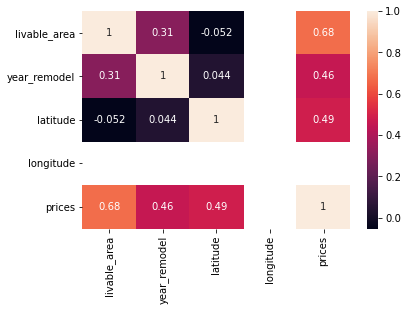

In [329]:
sns.heatmap(df_dummy[['livable_area', 'year_remodel', 'latitude', 'longitude', 'prices']].corr(), annot=True)

In [310]:
# choose the low/high price to categorize the housee to low/medium/high

low = df_dummy.prices.describe().values[4]
high = df_dummy.prices.describe().values[6]

# categorize house price to low (<low price), medium(>=low price & < high price), high (>= high price)
# 0 -> low price; 1-> medium price; 2-> high price
def categorize_price(x):
    if x < low:
        return 0
    elif x>=high:
        return 2
    else:
        return 1
df_dummy['price_category'] = df_dummy.prices.apply(categorize_price)

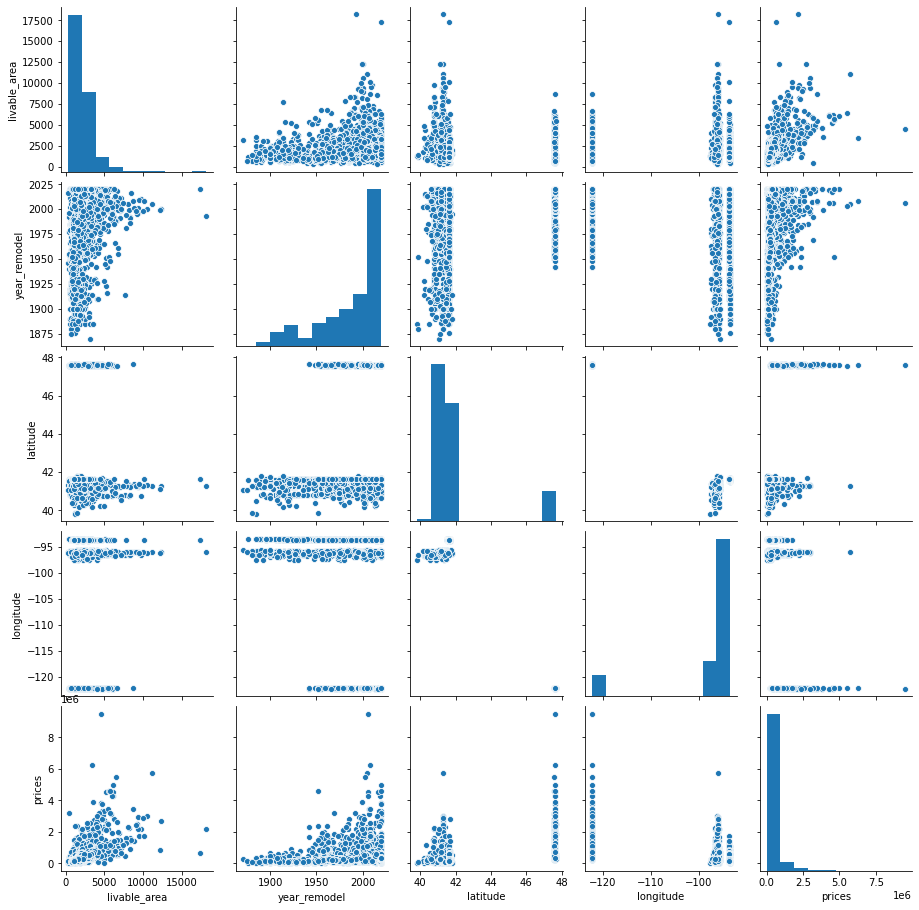

In [315]:
sns.pairplot(df_dummy[['livable_area', 'year_remodel', 'latitude', 'longitude', 'prices']])

Skewess:  5.587951617490799
Kurtosis:  51.92286329389947


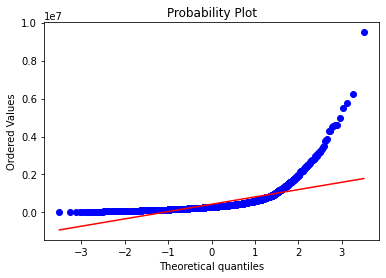

In [338]:
# see probability plot
_ = stats.probplot(df_dummy.prices, plot=plt)

# skew & kurt

print('Skewess: ', df_dummy.prices.skew())
print('Kurtosis: ', df_dummy.prices.kurt())

In [339]:
df_dummy.prices = df_dummy.prices.apply(np.log1p)
print('Skewess: ', df_dummy.prices.skew())
print('Kurtosis: ', df_dummy.prices.kurt())

Skewess:  0.34338489573579895
Kurtosis:  2.02219686652188


In [340]:
# check all skewness

for col in ['livable_area', 'year_remodel']:
    print(col, ': ', df_dummy[col].skew())

livable_area :  2.9606688424995555
year_remodel :  -1.0629720490043828


In [341]:
# fix skewness

lam = 0.15
for col in ['livable_area', 'year_remodel']:
    df_dummy[col] = boxcox1p(df_dummy[col], lam)
    df_dummy[col] = df_dummy[col] + 1

In [9]:
# rename df_dummy
df_final = df_dummy.copy()
cols = list(df_final.columns)
cols.remove('year_built')
df_final = df_final[cols]
df_final.to_csv('df-final.csv')

In [77]:
# reload data

df_final = pd.read_csv('df_final.csv', index_col=0)

## Step 5: Complement the zillow data with Foursquare nearby venues

In [90]:
# import libraries

import pandas as pd
import numpy as np
import requests
from collections import Counter

# set up parameters for Four squares API

CLIENT_ID = 'your id' # your Foursquare ID
CLIENT_SECRET = 'your secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit number

In [91]:
# help function to get nearby venues

# a radius of 3200 meters is used here, which is close to 2 miles
def getNearbyVenues(latitudes, longitudes, radius=3200):
    venues_lists = []
    for lat,lng in zip(latitudes, longtitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        try:    
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            v_list = [v['venue']['categories'][0]['name'] for v in results]
        except Exception as e:
            v_list = []
            pass
    
        venues_lists.append(v_list)
    return(venues_lists)

In [92]:
# put it all together

longtitudes = df_final.longitude.values
latitudes = df_final.latitude.values

df_final['nearby_venues'] = getNearbyVenues(latitudes, longtitudes)

In [93]:
# save data

df_final.to_csv('df_final_v3.csv')

In [94]:
# display last 5

df_final.tail()

,num_bedroom,num_bathroom,livable_area,num_parking,num_garage,lot_size,year_remodel,school_rating,latitude,longitude,...,roof_asphalt_compisition,roof_metal,roof_other,roof_rubber,roof_tile_slate,roof_unknown,roof_wood_cedar,prices,price_category,nearby_venues
3039,5.0,3.0,2241.0,2.0,2.0,13503.6,1964,4,41.620189,-93.719201,...,1,0,0,0,0,0,0,299500.0,1,"[Eastern European Restaurant, Ice Cream Shop, ..."
3040,3.0,2.0,1114.0,2.0,2.0,10018.8,1970,5,41.642583,-93.708921,...,1,0,0,0,0,0,0,215105.0,1,"[Coffee Shop, Multiplex, Asian Restaurant, Res..."
3041,3.0,3.0,1650.0,2.0,2.0,15681.6,1979,7,41.624912,-93.751430,...,1,0,0,0,0,0,0,251277.0,1,"[Salon / Barbershop, Toy / Game Store, Park, G..."
3042,3.0,2.0,1120.0,2.0,2.0,10018.8,1967,5,41.638287,-93.703530,...,1,0,0,0,0,0,0,208984.0,1,"[Coffee Shop, Multiplex, Asian Restaurant, Res..."
3043,3.0,3.0,1144.0,2.0,2.0,1742.4,2003,8,41.638044,-93.830826,...,0,0,1,0,0,0,0,182259.0,0,"[Gym, Grocery Store, Sports Bar, Furniture / H..."


In [95]:
# count number of venues

venue_values = df_final.nearby_venues.values.flatten()

# pull all of the venues into a single list

total_v = []
for v in venue_values:
    total_v.extend(v)

# convert it to a set to see the unique values
unique_venues  = set(total_v)

# print the number of unique venues
print(f'There are {len(unique_venues)} unique venues.')

There are 444 unique venues.


In [96]:
# add new features 

unique_venues = list(unique_venues)

for venue in unique_venues:
    # rename the column name by substitue ' ' with '_'
    col = '_'.join(venue.split())
    df_final[col] = df_final.nearby_venues.apply(lambda x:Counter(x)[venue])

In [97]:
df_final.drop(columns=['nearby_venues'], inplace=True)

In [104]:
# re-order columns

new_columns = list(df_final.columns)
new_columns.remove('prices')
new_columns.remove('price_category')
new_columns.append('prices')
#new_columns.append('price_category')

In [105]:
df_final = df_final[new_columns]

In [106]:
# print the final dimension of the dataset

df_final.shape

(3044, 485)

In [107]:
# display & save

df_final.to_csv('df_final_v4.csv')

In [114]:
df_final.head()

,num_bedroom,num_bathroom,livable_area,num_parking,num_garage,lot_size,year_remodel,school_rating,latitude,longitude,...,Laundromat,Intersection,Tennis_Court,Locksmith,Monument_/_Landmark,Soccer_Field,Bike_Shop,Hardware_Store,Plaza,prices
0,5.0,5.0,4319.0,2.0,3.0,11325.6,2013,8,41.251022,-96.223930,...,0,0,0,0,0,0,0,1,0,529500.0
1,2.0,2.0,720.0,2.0,1.0,7405.2,1951,3,41.615270,-93.688860,...,0,0,0,0,0,0,0,0,0,132900.0
2,2.0,2.0,1535.0,1.0,1.0,9583.2,2002,2,41.584598,-93.627449,...,0,0,0,0,0,0,0,0,1,358500.0
3,3.0,3.0,1624.0,2.0,2.0,9583.2,2020,7,41.565910,-93.819442,...,0,0,0,0,0,0,0,1,0,271900.0
4,4.0,2.0,1827.0,2.0,2.0,7405.2,1964,1,41.308938,-96.013697,...,0,1,1,0,0,0,0,1,0,165000.0


## Step 6: Regression Models

In [133]:
# record models and performances

_estimators = []
_r2 = []
_mse = []

In [177]:
# import library for machine learning

from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error, log_loss, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [110]:
# shuffle the dataset

df_final = df_final.sample(frac=1)
df_final.reset_index(drop=True, inplace=True)

# train-test split ( 25% for test)
X = df_final.iloc[:, :-1]
y_r = df_final.iloc[:, -1]

# for regression
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_r, test_size=0.25)

# for classification
# X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_c, test_size=0.25) 

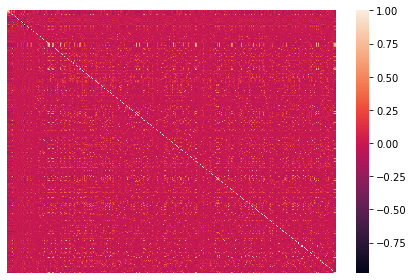

In [197]:
# display correlation between features

sns.heatmap(X.corr(), xticklabels=False, yticklabels=False)
plt.tight_layout()
plt.savefig('correlation.png')

In [111]:
# normalization the numeric features

X_norm = X.copy()
for col in X.columns:
    temp_mean = X[col].mean()
    temp_std = X[col].std()
    X_norm[col] = (X[col]-temp_mean)/temp_std

In [120]:
y_norm = (y_r-y_r.mean())/y_r.std()

### 6.1 Lasso regression

In [131]:
# split normalized data

X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y_norm, test_size=0.25)

# grid search lasso
lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}

lasso_norm = Lasso(random_state=1, max_iter=10000)
clf_lasso_norm = GridSearchCV(lasso_norm, lasso_params)
clf_lasso_norm.fit(X_train_norm, y_train_norm)

C:\Users\Jun\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6567107752523498, tolerance: 0.19070579000134394
  positive)


GridSearchCV(estimator=Lasso(max_iter=10000, random_state=1),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1]})

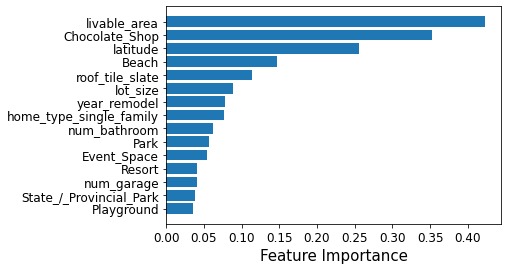

In [180]:
lasso_norm_feature_index = np.argsort(clf_lasso_norm.best_estimator_.coef_)[-15:]
_ = plt.barh(range(15), clf_lasso_norm.best_estimator_.coef_[lasso_norm_feature_index])
_ = plt.yticks(range(15), X_train_norm.columns[lasso_norm_feature_index], fontsize=12)
plt.xlabel('Feature Importance', fontsize=15)
plt.xticks(fontsize=12)
plt.savefig('lasso-norm.png')

In [134]:
# records lasso-norm performance

_estimators.append('lasso-norm')
_r2.append(r2_score(y_test_norm, clf_lasso_norm.best_estimator_.predict(X_test_norm)))
_mse.append(mean_squared_error(y_test_norm, clf_lasso_norm.best_estimator_.predict(X_test_norm)))

### 6.2 Ridge

In [178]:
ridge_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

ridge_norm = Ridge(random_state=1, max_iter=10000)
clf_ridge_norm = GridSearchCV(ridge_norm, ridge_params)
clf_ridge_norm.fit(X_train_norm, y_train_norm)

_estimators.append('ridge-norm')
_r2.append(r2_score(y_test_norm, clf_ridge_norm.best_estimator_.predict(X_test_norm)))
_mse.append(mean_squared_error(y_test_norm, clf_ridge_norm.best_estimator_.predict(X_test_norm)))

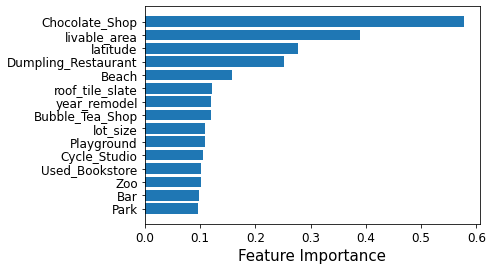

In [179]:
ridge_norm_feature_index = np.argsort(clf_ridge_norm.best_estimator_.coef_)[-15:]
_ = plt.barh(range(15), clf_ridge_norm.best_estimator_.coef_[ridge_norm_feature_index])
_ = plt.yticks(range(15), X_train_norm.columns[ridge_norm_feature_index], fontsize=12)
plt.xlabel('Feature Importance', fontsize=15)
plt.xticks(fontsize=12)
plt.savefig('ridge-norm.png')

### 6.3 RF Regressor

In [136]:
# RF parameter grid

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_r, y_train_r)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [137]:
_estimators.append('random forest')
_r2.append(r2_score(y_test_r, rf_random.best_estimator_.predict(X_test_r)))
_mse.append(mean_squared_error(y_test_r, rf_random.best_estimator_.predict(X_test_r)))

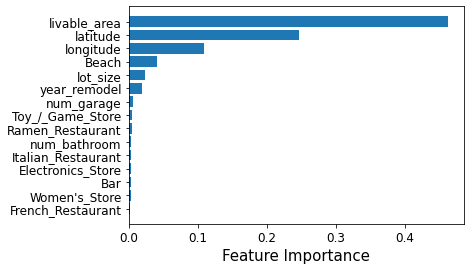

In [146]:
# plot feature importance
rf_feature_importance_idx= np.argsort(rf_random.best_estimator_.feature_importances_)[-15:]
_ = plt.barh(range(15), rf_random.best_estimator_.feature_importances_[rf_feature_importance_idx])
_ = plt.yticks(range(15), X_train_r.columns[rf_feature_importance_idx], fontsize=12)
plt.xlabel('Feature Importance', fontsize=15)
plt.xticks(fontsize=12)
plt.savefig('random_forest.png')

### 6.3 RF with feature selection from model 

In [148]:
# use recursive feature elimination cross valiation 
# for features selection

from sklearn.feature_selection import RFECV, RFE
rfr = RandomForestRegressor()
selector = RFE(rfr, n_features_to_select = 0.3, step=5)
selector.fit(X, y_r)

RFE(estimator=RandomForestRegressor(), n_features_to_select=0.3, step=5)

In [169]:
# choose the selected features

selected_cols = X.columns[np.where(selector.support_ == True)]
X_selected = X[selected_cols]

In [170]:
# redo train-test split

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected, y_r, test_size=0.25)


# RF parameter grid for search

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid_sel = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_sel = RandomizedSearchCV(estimator = rf, param_distributions = random_grid_sel, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random_sel.fit(X_train_sel, y_train_sel)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40, 45, 50, 55, 60, 65,
                                                      70, 75, 80, 85, 90, 95,
                                                      100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=42, verbose=2)

In [172]:
_estimators.append('random forest (RFE)')
_r2.append(r2_score(y_test_sel, rf_random_sel.best_estimator_.predict(X_test_sel)))
_mse.append(mean_squared_error(y_test_sel, rf_random_sel.best_estimator_.predict(X_test_sel)))

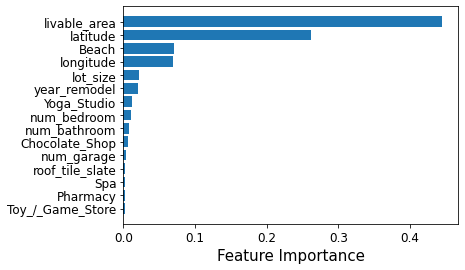

In [183]:
# plot feature importance
rf_feature_importance_idx2= np.argsort(rf_random_sel.best_estimator_.feature_importances_)[-15:]
_ = plt.barh(range(15), rf_random_sel.best_estimator_.feature_importances_[rf_feature_importance_idx2])
_ = plt.yticks(range(15), X_train_sel.columns[rf_feature_importance_idx2], fontsize=12)
plt.xlabel('Feature Importance', fontsize=15)
plt.xticks(fontsize=12)
plt.savefig('random_forest_rfe.png')

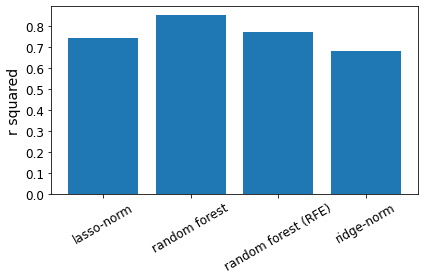

In [203]:
_ = plt.bar(range(4), _r2)
plt.xticks(range(4), _estimators, rotation=30, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('r squared', fontsize=14)
plt.tight_layout()
plt.savefig('model_performance.png')